Import packages and define some functions to use such as parse csv


In [1]:
import csv
import time
import numpy as np
import matplotlib.pyplot as plt 
from collections import Counter

N = 6301        # number of nodes

def random_walk(adj, initial_node, steps):
    """
        Perform a random walk of the given number of steps on the given
        graph starting at initial node.

        Returns a tuple containing the normalized degree distribution (which is a
        Counter object (a bag), where each element is of the form {degree: times_seen})
        and the average degree (which is an integer).
    """

    cur = initial_node
    total_deg = 0

    deg = Counter()

    for _ in range(steps):

        # record the degree of the current node
        d_i = sum(adj[cur])
        deg.update([d_i])
        total_deg += d_i

        # get a list of neighbors
        neighbors = [i for i,x in enumerate(adj[cur]) if x]

        # go to a neighbor with uniform probability
        next = np.random.choice(neighbors)
        cur = next

    return deg, total_deg/steps

def MH_random_walk(adj, degree, initial_node, steps, verbose=False):
    """
        Perform a Metropolis-Hastings random walk of the given number of steps on the given
        graph starting at initial node.

        Returns a tuple containing the normalized degree distribution (which is a
        Counter object (a bag), where each element is of the form {degree: times_seen})
        and the average degree (which is an integer).
    """

    cur = initial_node
    total_deg = 0

    deg = Counter()

    for _ in range(steps):

        # record the degree of the current node
        d_i = sum(adj[cur])
        deg.update([d_i])
        total_deg += d_i

        # get a list of neighbors
        neighbors = [i for i,x in enumerate(adj[cur]) if x]

        # calculate the ("corrected") probability of each transition
        probabilities = []
        for n in neighbors:

            # calculate the probability of accepting the transition (see theory)
            a = min(1, degree[cur]/degree[n])

            # combine it with the default probability of the transition to get the final one
            probabilities.append(a * (1/degree[cur]))

        # introduce a self loop to account for the reduced probabilities if needed
        if (sum(probabilities)<1):
            neighbors += [cur]
            probabilities.append(1-sum(probabilities))
        elif verbose:
            if (sum(probabilities)>1):
                # this may happen because of floating point arithmetic - things that sum to 1 may be summed to 1.000000000000000002 :)
                print(f"Warning: Probabilities of transition from node {cur} sum to {sum(probabilities)}>1 (deg={degree[cur]}, max deg of neighbors: {max([degree[n] for n in neighbors])}) ")

        # pick a neighbor to go to using the corrected probabilities
        next = np.random.choice(neighbors, p=probabilities)
        cur = next

    return deg, total_deg/steps

def triangles(adj):
    """
        Given the adjacency matrix of a graph, return the number of triangles
        it has multiplied by 3 (since each triangle is counted once by each
        node that is in it).
    """

    start_time = time.time()
    print("Counting triangles...", end="", flush=True)

    triangles = 0

    # we assume no self loops just because it holds for our dataset and simplifies the code a bit

    i = 0

    for _neighbors in adj:
        
        if i%200 == 0:
            print(".", end="", flush=True)
        i += 1

        neighbors_of_1 = set([i for i,x in enumerate(_neighbors) if x])

        for n in neighbors_of_1:
            neighbors_of_2 = set([i for i,x in enumerate(adj[n]) if x])
            triangles += len(neighbors_of_1 & neighbors_of_2)

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"done [{round(execution_time, 2)} sec]", flush=True)
    return triangles // 2   # divide by 2 because we double count triangles that each node partakes in

def triples(adj):
    """
        Given the adjacency matrix of a graph, return the number of triangles it CAN have.
    """

    start_time = time.time()
    print("Counting triples...", end="", flush=True)

    pos_tri = 0     # possible triangles
    
    i = 0

    for _neighbors in adj:
        
        if i%200 == 0:
            print(".", end="", flush=True)
        i += 1

        num_neighbors = sum(_neighbors)

        pos_tri += (num_neighbors * (num_neighbors-1)) // 2    # divide by 2 because undirected edges are counted from both neighbors

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"done [{round(execution_time*1000)} ms]", flush=True)
    return pos_tri

def parse_csv(filename):
    """
        Parse the given csv file and return the adjacency matrix and degree
        sequence of the graph described in it.
    """

    adj = [[0 for _ in range(N)] for _ in range (N)]    # the adjacency matrix
    deg = [0 for _ in range(N)]                         # the degree array (deg[i] is degree of node i)

    start_time = time.time()
    print("Parsing...", end="", flush=True)

    # parse the csv
    with open(filename, "r") as f:

        # initialize the reader
        dataset = list(csv.reader(f))

        i=0

        for row in dataset:
            
            if i%1000 == 0:
                print(".", end="", flush=True)
            i += 1
            
            node1, node2 = int(row[0])-1, int(row[1])-1
            adj[node1][node2] = 1
            adj[node2][node1] = 1
            deg[node1] += 1
            deg[node2] += 1

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"done [{round(execution_time*1000)} ms]", flush=True)
    return adj, deg

1) Parse the file and create the adjacency matrix

In [2]:
# parse the input file
adj, deg = parse_csv("gnutella.csv")

Parsing........................done [157 ms]


2) Calculate p using the average degree and min/max degree

In [ ]:
# calculate stats
edges = sum([sum(x) for x in adj]) // 2
avg_deg = sum(deg)/N
p = avg_deg/(N-1)
density = edges/(N*(N-1))


# print stats
print(f"number of nodes: {N}")
print(f"number of edges: {edges}")

print(f"average degree <k>: {round(avg_deg, 3)}, according to which p is {round(p, 3)} (network density is {round(density, 3)})")




3a) Calculate min/max degree , plot degree distirbution and the ccdf of it

In [ ]:
# calculate min and max degreee
min_deg = min(deg)
max_deg = max(deg)
#polt min and max degree
print(f"min degree: {round(min_deg, 3)}")
print(f"max degree: {round(max_deg, 3)}")

# create the degree distribution (and its normalized counterpart)
deg_distr = np.unique(deg, return_counts=True)
normalized_deg_distr = [deg_distr[0], [x/N for x in deg_distr[1]]]




# calculate the (normalized) cdf and ccdf
cdf = [sum(normalized_deg_distr[1][:x-1]) for x in normalized_deg_distr[0]]
ccdf = [1-i for i in cdf]

"""
    plot the degree distribution on normal 
"""
plain_deg_distr_plot = plt.figure("True Degree Distribution").add_subplot()

plain_deg_distr_plot.set_title("True Degree Distribution")
plain_deg_distr_plot.set_xlabel("Degree k")
plain_deg_distr_plot.set_ylabel("% of nodes with deg k")
plain_deg_distr_plot.bar(*normalized_deg_distr, label="Degree Distribution")
plain_deg_distr_plot.legend()

"""
    plot the CCDF
"""

ccdf_plot = plt.figure("CCDF").add_subplot()

ccdf_plot.set_title("CCDF")
ccdf_plot.set_xlabel("Degree k")
ccdf_plot.set_ylabel("prob that a node has degree > k")
ccdf_plot.plot(normalized_deg_distr[0], ccdf, label="Complementary Cumulative Distribution Function")
ccdf_plot.legend()









3b) Plot the Log-Log degree distirbution along with some power law distirbutions in order to check if it is power law

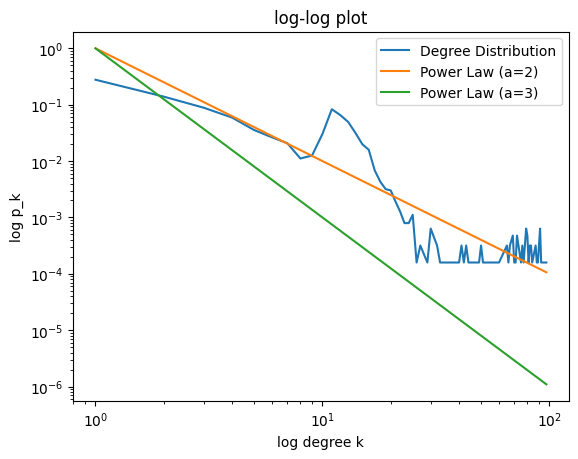

<Figure size 640x480 with 0 Axes>

In [6]:
# create the degree distribution (and its normalized counterpart)
deg_distr = np.unique(deg, return_counts=True)
normalized_deg_distr = [deg_distr[0], [x/N for x in deg_distr[1]]]


# create some power-law distributions to compare the degree distribution against
c = 1
a = 2
power_law_a2 = [c*(1/x**2) for x in normalized_deg_distr[0]]
power_law_a3 = [c*(1/x**3) for x in normalized_deg_distr[0]]

"""
    plot in log-log axes to determine whether the deg distr is power law
"""

log_log_plot = plt.figure("log-log plot").add_subplot()

log_log_plot.set_title("log-log plot")
log_log_plot.set_xlabel("log degree k")
log_log_plot.set_ylabel("log p_k")
log_log_plot.loglog(*normalized_deg_distr, label="Degree Distribution")
log_log_plot.loglog(normalized_deg_distr[0], power_law_a2, label="Power Law (a=2)")
log_log_plot.loglog(normalized_deg_distr[0], power_law_a3, label="Power Law (a=3)")
log_log_plot.legend()


"""
    plot degree distributions (true and measured)
"""
fig = plt.figure("Degree Distributions: True vs Measured")

4) Calculate the clustering coefficient by counting triangles and triples

In [ ]:
# Calculate the clustering coefficient
num_triangles = triangles(adj)
num_triples = triples(adj)
clust_coeff = num_triangles/num_triples
#print the clustering coefficient
print(f"clustering coefficient is {round(clust_coeff, 3)}")


5-6) Implement some  regular Random Walks , some MH Random Walks and plot degree distirbuton measured along with the real one


In [ ]:

# do 5 random walks from uniformly distributed initial nodes and measure degree distribution of visited nodes
num_random_walks = 5
steps = 400
c = Counter()
initials = [np.random.choice(range(N)) for _ in range(num_random_walks)]
for node in initials:
    c.update(random_walk(adj, node, steps)[0])

# prepare the measured degree distribution for plotting (sort, normalize and take care of the form)
c = sorted(c.items())
rw_norm_deg_distr = [
    [item[0] for item in c],
    [item[1]/(steps*num_random_walks) for item in c]
]
# print(f"sum of probabilities measured from random walks: {round(sum(rw_norm_deg_distr[1]), 3)}")


# do 5 modified (Metropolis-Hastings) random walks from uniformly distributed initial nodes and measure degree distribution of visited nodes
num_MH_random_walks = 5
MH_steps = 400
c = Counter()
initials = [np.random.choice(range(N)) for _ in range(num_MH_random_walks)]
for node in initials:
    c.update(MH_random_walk(adj, deg, node, MH_steps)[0])

# prepare the measured degree distribution for plotting (sort, normalize and take care of the form)
c = sorted(c.items())
MH_rw_norm_deg_distr = [
    [item[0] for item in c],
    [item[1]/(steps*num_random_walks) for item in c]
]

# print(f"sum of probabilities measured from MH random walks: {round(sum(MH_rw_norm_deg_distr[1]), 3)}")

"""
    plot degree distributions (true and measured)
"""
fig = plt.figure("Degree Distributions: True vs Measured")


deg_dist_plot = fig.add_subplot(311)
random_walk_plot = fig.add_subplot(312, sharey=deg_dist_plot)       # make them share y-axis for clearer visual comparison
MH_random_walk_plot = fig.add_subplot(313, sharey=deg_dist_plot)    # make them share y-axis for clearer visual comparison
fig.subplots_adjust(hspace=1)  # adjust the space between the plots to avoid titles overlapping

# plot the true degree distribution
deg_dist_plot.set_xlabel("Degree k")
deg_dist_plot.set_ylabel("% of nodes with deg k")
deg_dist_plot.bar(*normalized_deg_distr, label="True Degree Distribution")
deg_dist_plot.legend()

# plot the degree distribution that was measured from the random walks
random_walk_plot.set_xlabel("Degree k")
random_walk_plot.set_ylabel("% of nodes with deg k")
random_walk_plot.bar(*rw_norm_deg_distr, color="orange", label="Measured from Random Walks")
random_walk_plot.legend()

# plot the degree distribution that was measured from the MH random walks
MH_random_walk_plot.set_xlabel("Degree k")
MH_random_walk_plot.set_ylabel("% of nodes with deg k")
MH_random_walk_plot.bar(*MH_rw_norm_deg_distr, color="purple", label="Measured from MH Random Walks")
MH_random_walk_plot.legend()

"""
    compare the real and measured degree distributions on a log log plot
"""
deg_distr_comparison_plot = plt.figure("Degree Distribution Comparison on log-log plot").add_subplot()
deg_distr_comparison_plot.set_title("log-log plot")
deg_distr_comparison_plot.set_xlabel("log degree k")
deg_distr_comparison_plot.set_ylabel("log p_k")
deg_distr_comparison_plot.loglog(*normalized_deg_distr, label="True Degree Distribution")
deg_distr_comparison_plot.loglog(*rw_norm_deg_distr, label="measured from random walks")
deg_distr_comparison_plot.loglog(*MH_rw_norm_deg_distr, label="measured from MH random walks")
deg_distr_comparison_plot.legend()

plt.show()